---
authors:
  - name: Mathis Derenne
    affiliation: M2 MIASHS - Université de Lyon
    github: mathisdrn
  - name: Djida Boukari
    affiliation: M2 MIASHS - Université de Lyon
  - name: Ines Nakhli
    affiliation: M2 MIASHS - Université de Lyon
date: 2026-02-01
---

# Modèle de Cox

Ce notebook implémente un modèle de Cox pour prédire les risques de survie à partir de données censurées.

On fait une recherche par grille avec validation croisée pour déterminer le coefficient de penalité et la méthode de régularisation (L1, L2 ou ElasticNet).

En pratique, il faudrait standardiser les données sur chaque pli. En l'état une standardisation globale est faite avant la séparation des données, ce qui peut entraîner une légère fuite de données. Toutefois, la librairie `lifelines` ne supporte pas les pipelines scikit-learn, ce qui complique l'implémentation.

## Imports

In [44]:
import numpy as np
import pandas as pd
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt

# Polars display options
pl.Config.set_tbl_hide_dataframe_shape(True)
pl.Config.set_float_precision(3)
pl.Config.set_tbl_hide_column_data_types(True);

## Chargement des données

In [45]:
X_train = pl.read_parquet("../../data/df_study_L18_w6_train.parquet")
X_test = pl.read_parquet("../../data/df_study_L18_w6_test.parquet")

## Entraînement du modèle

In [46]:
from itertools import product
from tqdm.auto import tqdm
from lifelines import CoxPHFitter
from lifelines.utils import k_fold_cross_validation

penalizers = [0.1, 1.0]
l1_ratios = [0.0, 0.5, 1.0]
grid = list(product(penalizers, l1_ratios))

results = []

# Pour réduire le temps d'exécution.
X_train_sub = X_train.sample(fraction=0.4, seed=42)

for p, l1 in tqdm(grid, desc="Hyperparameter tuning"):
    cph = CoxPHFitter(alpha=0.05, penalizer=p, l1_ratio=l1)

    scores = k_fold_cross_validation(
        cph,
        X_train_sub.to_pandas(),
        duration_col="time",
        event_col="event",
        k=2,
        scoring_method="concordance_index",
    )

    results.append(
        {
            "penalizer": p,
            "l1_ratio": l1,
            "mean_c_index": np.mean(scores),
            "std_err": np.std(scores),
        }
    )

pl.DataFrame(results).sort("mean_c_index", descending=True)

Hyperparameter tuning:   0%|          | 0/6 [00:00<?, ?it/s]

penalizer,l1_ratio,mean_c_index,std_err
0.100,1.000,0.700,0.017
0.100,0.500,0.697,0.021
0.100,0.000,0.683,0.006
1.000,1.000,0.677,0.008
1.000,0.000,0.667,0.002
1.000,0.500,0.657,0.002


Dans l'ordre de performance, le meilleur modèle est un modèle de Cox pénalisé avec un coefficient de pénalisation de 0.1 et une régularisation ElasticNet (poids L1 = 0.5), suivi d'un modèle de Cox pénalisé avec un coefficient de pénalisation de 1.0 et une régularisation L1.

## Entraînement du modèle final

On utilise un coefficient de pénalisation de 0.1 avec une régularisation ElasticNet.

In [47]:
cph = CoxPHFitter(alpha=0.05, penalizer=0.1, l1_ratio=0.5)
cph.fit(X_train.to_pandas(), duration_col="time", event_col="event")

<lifelines.CoxPHFitter: fitted with 2381 total observations, 780 right-censored observations>

## Évaluation du modèle final

In [48]:
from utils import evaluate_survival_model

risk_cox = cph.predict_partial_hazard(X_test.to_pandas()).values.ravel()
surv_cox = cph.predict_survival_function(X_test.to_pandas())
evaluate_survival_model(X_train, X_test, risk_cox, surv_cox)

C-index,Mean td-AUC,IBS,Brier (t=1210.0)
0.708,0.762,0.185,0.199


In [49]:
ll_ratio_test = cph.log_likelihood_ratio_test()

metrics = {
    "Concordance": cph.concordance_index_,
    "Partial AIC": cph.AIC_partial_,
    "log-likelihood ratio test": ll_ratio_test.test_statistic,
    "p-value (test)": ll_ratio_test.p_value,
    "-log2(p) of II-ratio test": ll_ratio_test.summary["-log2(p)"].values[0],
}
pl.DataFrame(metrics, orient="row")

Concordance,Partial AIC,log-likelihood ratio test,p-value (test),-log2(p) of II-ratio test
0.716,22448.291,281.014,0.980,0.028


In [50]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
pca0,7.158326e-02,1.074208,0.007825,0.056247,0.086920,1.057859,1.090809,0.0,9.148175,5.790329e-20,63.904917
pca1,-1.042333e-01,0.901015,0.009434,-0.122723,-0.085743,0.884508,0.917830,0.0,-11.048932,2.218388e-28,91.864475
pca2,-7.166437e-09,1.000000,0.000007,-0.000013,0.000013,0.999987,1.000013,0.0,-0.001055,9.991585e-01,0.001214
pca3,2.679475e-02,1.027157,0.008971,0.009211,0.044378,1.009254,1.045378,0.0,2.986706,2.820007e-03,8.470086
pca4,-9.483754e-09,1.000000,0.000008,-0.000016,0.000016,0.999984,1.000016,0.0,-0.001197,9.990449e-01,0.001379
...,...,...,...,...,...,...,...,...,...,...,...
pca327,-3.532080e-09,1.000000,0.000024,-0.000047,0.000047,0.999953,1.000047,0.0,-0.000148,9.998821e-01,0.000170
pca328,-3.696161e-09,1.000000,0.000024,-0.000047,0.000047,0.999953,1.000047,0.0,-0.000154,9.998768e-01,0.000178
pca329,1.152443e-08,1.000000,0.000025,-0.000048,0.000048,0.999952,1.000048,0.0,0.000468,9.996264e-01,0.000539


In [51]:
cph.baseline_survival_

,baseline survival
540.0,0.998868
541.0,0.998490
542.0,0.998112
543.0,0.997735
545.0,0.996601
...,...
10549.0,0.008397
10559.0,0.008397
10627.0,0.008397
10786.0,0.004282


## Courbe de calibration

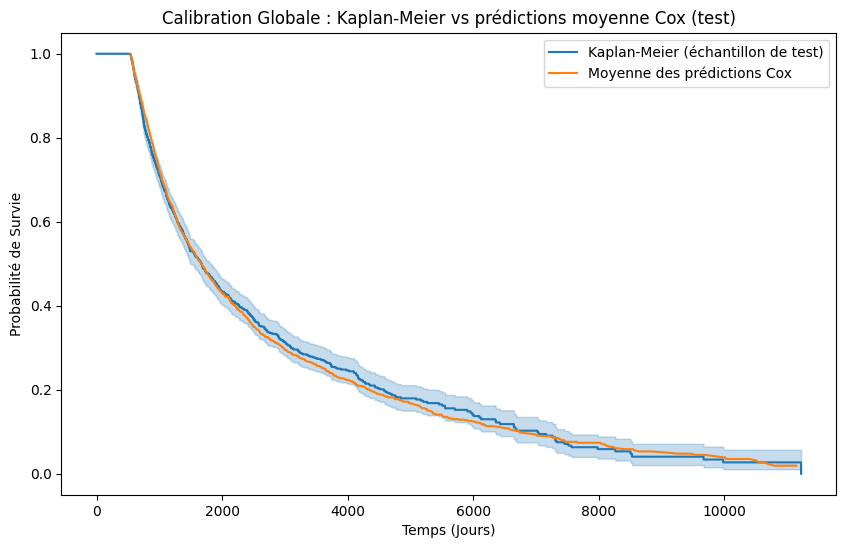

In [58]:
from lifelines import KaplanMeierFitter

df_test = X_test.to_pandas()

# Kaplan-Meier sur l'échantillon de test
kmf = KaplanMeierFitter()
kmf.fit(
    durations=df_test["time"],
    event_observed=df_test["event"],
    label="Kaplan-Meier (échantillon de test)",
)

# Prédictions du modèle Cox
predicted_surv_curves = cph.predict_survival_function(df_test)

# Survie moyenne prédite par le modèle pour toute la cohorte
average_predicted_survival = predicted_surv_curves.mean(axis=1)

# Visualisation
plt.figure(figsize=(10, 6))
kmf.plot_survival_function(ax=plt.gca(), ci_show=True)
plt.plot(
    average_predicted_survival.index,
    average_predicted_survival.values,
    label="Moyenne des prédictions Cox",
)

plt.title("Calibration Globale : Kaplan-Meier vs prédictions moyenne Cox (test)")
plt.xlabel("Temps (Jours)")
plt.ylabel("Probabilité de Survie")
plt.legend();

ICI =  0.40987472436849903
E50 =  0.4259075782779233


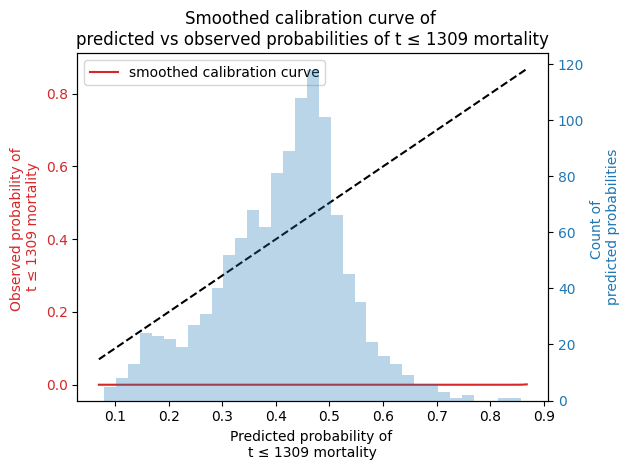

In [53]:
from lifelines.calibration import survival_probability_calibration

# Choix du temps t0 comme la médiane des temps d'événements observés dans le jeu de test
t0 = X_test.get_column("time").quantile(0.5)
survival_probability_calibration(cph, X_test.to_pandas(), t0=t0);